In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

In [2]:
#for replicability purposes
tf.random.set_seed(91195003)
np.random.seed(91195003)

#for an easy reset backend session state
tf.keras.backend.clear_session()

In [3]:
#load dataset
def load_dataset(path):
  return pd.read_csv(path)

In [4]:
#split data into training and validation sets
def split_data(training, perc=10):
  train_idx = np.arange(0,int(len(training)*(100-perc)/100))
  val_idx = np.arange(int(len(training)* (100-perc)/100+1),len(training))
  return train_idx, val_idx


In [5]:
#preparing the data for the LSTM
def prepare_data(df):
  df_aux = df.drop(columns=['Wind_Speed','Wind_Direction','Visibility','Cloud_Cover','Relative_Humidity','Rain','Clear','Partially_cloudy',
                            'confirmados_arsalentejo','confirmados_acores','confirmados_madeira','confirmados_novos','internados_uci','obitos_arsnorte',
                                'obitos_arslvt','obitos_arsalentejo',
       'obitos_arsalgarve', 'obitos_acores', 'obitos_madeira','ativos','confirmados_10_19','confirmados_70_79',
       'confirmados_80_plus', 'obitos_0_9', 'obitos_10_19', 'obitos_20_29',
       'obitos_30_39', 'obitos_40_49', 'obitos_50_59', 'obitos_60_69',
       'obitos_70_79', 'obitos_80_plus', 'Max_Temp', 'Min_Temp', 'Temperature',
       'Precipitation'], inplace=False)
  df_aux = df_aux.set_index('Date')
  return df_aux


In [6]:

def data_normalization(df, norm_range=(-1, 1)):
#[-1, 1] for LSTM due to the internal use of tanh by the memory cell
  scaler = MinMaxScaler(feature_range=norm_range)
  df[['confirmados']] = scaler.fit_transform(df[['confirmados']])
  df[['confirmados_arsnorte']] = scaler.fit_transform(df[['confirmados_arsnorte']])
  df[['confirmados_arscentro']] = scaler.fit_transform(df[['confirmados_arscentro']])
  df[['confirmados_arslvt']] = scaler.fit_transform(df[['confirmados_arslvt']])
  df[['confirmados_arsalgarve']] = scaler.fit_transform(df[['confirmados_arsalgarve']])
  df[['recuperados']] = scaler.fit_transform(df[['recuperados']])
  df[['obitos_arscentro']] = scaler.fit_transform(df[['obitos_arscentro']])
  df[['internados_enfermaria']] = scaler.fit_transform(df[['internados_enfermaria']])
  df[['confirmados_0_9']] = scaler.fit_transform(df[['confirmados_0_9']])
  df[['confirmados_20_29']] = scaler.fit_transform(df[['confirmados_20_29']])
  df[['confirmados_30_39']] = scaler.fit_transform(df[['confirmados_30_39']])
  df[['confirmados_40_49']] = scaler.fit_transform(df[['confirmados_40_49']])
  df[['confirmados_50_59']] = scaler.fit_transform(df[['confirmados_50_59']])
  df[['confirmados_60_69']] = scaler.fit_transform(df[['confirmados_60_69']])
  df[['obitos']] = scaler.fit_transform(df[['obitos']])
  return scaler



In [7]:
#plot learning curve
def plot_learning_curves(history, epochs):
  #accuracies and losses
  #dict_keys(['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse'])
  loss=history.history['loss']
  val_loss=history.history['val_loss']
  epochs_range = range(epochs)
  #creating figure
  plt.figure(figsize=(8,8))
  plt.subplot(1,2,2)
  plt.plot(epochs_range,loss,label='Training Loss')
  plt.plot(epochs_range,val_loss,label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training/Validation Loss')
  plt.show()


In [8]:
#Plot time series data
def plot_confirmed_cases(data):
  plt.figure(figsize=(8,6))
  plt.plot(range(len(data)), data)
  plt.title('Confirmed Deaths')
  plt.ylabel('Óbitos')
  plt.xlabel('Days')
  plt.show()


In [9]:
#Preparing the dataset for the CNN
def to_supervised(df, timesteps):
  data = df.values
  X,y = list(), list()
  #iterate over the training set to create X and y
  dataset_size = len(data)
  for curr_pos in range(dataset_size):
    #end of the input sequence is the current position + the number of the timesteps of the input sequence
    input_index = curr_pos + timesteps
    #end of the labels corresponds to the end of the input sequence + 1
    label_index = input_index + 1
    #if we have enough data for this sequence
    if label_index < dataset_size:
      X.append(data[curr_pos:input_index,:])
      y.append(data[input_index:label_index,10])
        #using np.flot32 for GPU performance
  return np.array(X).astype('float32'), np.array(y).astype('float32')

In [10]:
#Building the model
def rmse(y_true, y_pred):
  return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true)))


In [11]:
def build_model(timesteps, features, filters= 16, kernel_size=5, pool_size =2 ):
  #using the functional API
  inputs = tf.keras.layers.Input(shape=(timesteps, features))
  #microarchitecture
  x = tf.keras.layers.Conv1D(filters=filters, kernel_size = kernel_size, activation='relu', data_format = 'channels_last')(inputs)
  x = tf.keras.layers.AveragePooling1D(pool_size = pool_size, data_format = 'channels_first')(x)
  #last layers
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(filters)(x)
  outputs = tf.keras.layers.Dense(1)(x)
  #the model
  cnnModel = tf.keras.Model(inputs=inputs, outputs=outputs, name='cnn_model')
  tf.keras.utils.plot_model(cnnModel,'cnnmodel.png', show_shapes=True)
  return cnnModel

In [12]:
def compile_and_fit(model, epochs, batch_size):
  #compile
  model.compile(loss=rmse, optimizer = tf.keras.optimizers.Adam(), metrics = ['mae',rmse])
  #fit
  hist_list = list()
  loss_list = list()
  #Time Series Cross Validator
  tscv = TimeSeriesSplit(n_splits=cv_splits)
  for train_index, test_index in tscv.split(X):
    train_idx, val_idx = split_data(train_index, perc=10) #further split into training and validation sets
    #build data
    X_train, y_train = X[train_idx], y[train_idx]
    X_val, y_val = X[val_idx], y[val_idx]
    X_test, y_test = X[test_index], y[test_index]
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size,shuffle=False)
    metrics = model.evaluate(X_test, y_test)

    plot_learning_curves(history, epochs)
    hist_list.append(history)

  return model, hist_list

In [13]:
def forecast(model, df, timesteps, multisteps, scaler):
  input_seq = df[-timesteps:].values #getting the last sequence of known value
  inp = input_seq
  forecasts = list()
  print(inp)
  #multistep tells us how many iterations we want to perform
  #i. e. how many days we want to predict
  for step in range(1, multisteps+1):
    #implement
    inp = inp.reshape(1, timesteps, n_variate)
    pred = model.predict(inp)
    yhat_inversed = scaler.inverse_transform(pred)
    forecasts.append(yhat_inversed)
    print(step)
            
  return forecasts

In [14]:
def plot_forecast(data, forecasts):
  plt.figure(figsize=(8,6))
  plt.plot(range(len(data)),data, color='green', label='Confirmed')
  plt.plot(range(len(data)-1,len(data)+len(forecasts)-1), forecasts, color='red', label='Forecasts')
    
  plt.title('Deaths count')
  plt.ylabel('Price')
  plt.xlabel('Days')
  plt.legend()
  plt.show()

Index(['confirmados', 'confirmados_arsnorte', 'confirmados_arscentro',
       'confirmados_arslvt', 'confirmados_arsalgarve', 'recuperados', 'obitos',
       'obitos_arscentro', 'internados_enfermaria', 'confirmados_0_9',
       'confirmados_20_29', 'confirmados_30_39', 'confirmados_40_49',
       'confirmados_50_59', 'confirmados_60_69'],
      dtype='object')
(422, 15)
Epoch 1/10
19/19 [==============================] - 1s 30ms/step - loss: 0.5733 - mae: 0.5733 - rmse: 0.5730 - val_loss: 0.0956 - val_mae: 0.0956 - val_rmse: 0.0956
Epoch 2/10
19/19 [==============================] - 0s 3ms/step - loss: 0.1068 - mae: 0.1068 - rmse: 0.1068 - val_loss: 0.0693 - val_mae: 0.0693 - val_rmse: 0.0693
Epoch 3/10
19/19 [==============================] - 0s 4ms/step - loss: 0.0478 - mae: 0.0477 - rmse: 0.0478 - val_loss: 0.0490 - val_mae: 0.0490 - val_rmse: 0.0490
Epoch 4/10
19/19 [==============================] - 0s 4ms/step - loss: 0.0325 - mae: 0.0325 - rmse: 0.0325 - val_loss: 0.0041 - val_

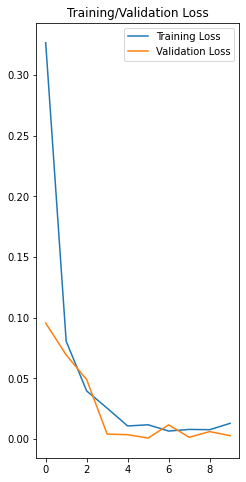

Epoch 1/10
38/38 [==============================] - 0s 3ms/step - loss: 0.0121 - mae: 0.0120 - rmse: 0.0121 - val_loss: 0.0043 - val_mae: 0.0041 - val_rmse: 0.0043
Epoch 2/10
38/38 [==============================] - 0s 2ms/step - loss: 0.0189 - mae: 0.0189 - rmse: 0.0187 - val_loss: 0.0041 - val_mae: 0.0039 - val_rmse: 0.0041
Epoch 3/10
38/38 [==============================] - 0s 2ms/step - loss: 0.0134 - mae: 0.0133 - rmse: 0.0132 - val_loss: 0.0127 - val_mae: 0.0126 - val_rmse: 0.0127
Epoch 4/10
38/38 [==============================] - 0s 2ms/step - loss: 0.0140 - mae: 0.0139 - rmse: 0.0141 - val_loss: 0.0131 - val_mae: 0.0130 - val_rmse: 0.0131
Epoch 5/10
38/38 [==============================] - 0s 2ms/step - loss: 0.0161 - mae: 0.0160 - rmse: 0.0160 - val_loss: 0.0053 - val_mae: 0.0051 - val_rmse: 0.0053
Epoch 6/10
38/38 [==============================] - 0s 2ms/step - loss: 0.0150 - mae: 0.0150 - rmse: 0.0150 - val_loss: 0.0225 - val_mae: 0.0225 - val_rmse: 0.0225
Epoch 7/10
38/38

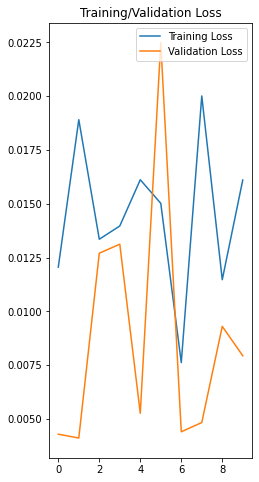

Epoch 1/10
56/56 [==============================] - 0s 3ms/step - loss: 0.0180 - mae: 0.0177 - rmse: 0.0181 - val_loss: 0.1365 - val_mae: 0.1353 - val_rmse: 0.1600
Epoch 2/10
56/56 [==============================] - 0s 2ms/step - loss: 0.0469 - mae: 0.0467 - rmse: 0.0469 - val_loss: 0.1099 - val_mae: 0.1090 - val_rmse: 0.1255
Epoch 3/10
56/56 [==============================] - 0s 2ms/step - loss: 0.1137 - mae: 0.1136 - rmse: 0.1134 - val_loss: 0.1003 - val_mae: 0.0993 - val_rmse: 0.1151
Epoch 4/10
56/56 [==============================] - 0s 2ms/step - loss: 0.1094 - mae: 0.1093 - rmse: 0.1092 - val_loss: 0.0976 - val_mae: 0.0969 - val_rmse: 0.1110
Epoch 5/10
56/56 [==============================] - 0s 2ms/step - loss: 0.0876 - mae: 0.0875 - rmse: 0.0873 - val_loss: 0.0796 - val_mae: 0.0787 - val_rmse: 0.0933
Epoch 6/10
56/56 [==============================] - 0s 2ms/step - loss: 0.0634 - mae: 0.0632 - rmse: 0.0632 - val_loss: 0.0686 - val_mae: 0.0676 - val_rmse: 0.0817
Epoch 7/10
56/56

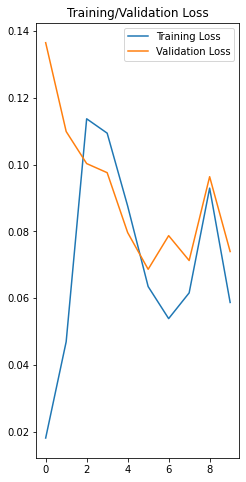

[[ 0.9928442   0.99264009  0.99548582  0.99424     0.98379511  0.99099057
   0.99775891  0.99734131 -0.89073951  0.99118372  0.992935    0.99131023
   0.99336422  0.99397576  0.99318557]
 [ 0.99440263  0.99418262  0.99636499  0.99549604  0.98817229  0.99267668
   0.99834867  0.99734131 -0.89606929  0.99260988  0.99468443  0.99328214
   0.99469427  0.99541704  0.99464749]
 [ 0.99546159  0.99533653  0.99714271  0.99618749  0.99171129  0.9936752
   0.99870252  0.99800598 -0.89373751  0.99433856  0.99582829  0.99480285
   0.99543158  0.99634011  0.9955435 ]
 [ 0.99598987  0.99591648  0.99754848  0.99654273  0.99217695  0.99505796
   0.99882048  0.99800598 -0.88607595  0.99403604  0.99587875  0.99557156
   0.99612552  0.99682594  0.99627446]
 [ 0.99700801  0.99668774  0.99812332  0.99751331  0.99478463  0.99733812
   0.99941024  0.99867065 -0.89473684  0.99503004  0.99707307  0.99680818
   0.99720979  0.99742512  0.99717048]
 [ 0.99847279  0.9983917   0.99901939  0.99871225  0.99655413  0.9

In [15]:
################################
################################
########                ########
######## Main Execution ########
########                ########
################################
################################

#Number os variables to use
n_variate = 15
#the dataframes
path=r'daily_covid.csv'
df_raw = load_dataset(path)
df_data = prepare_data(df_raw)
df = df_data.copy()

print(df.columns)

print(df.shape)

scaler = data_normalization(df) #scaling data to [-1, 1]


##Optimization

tunning_dict = {
                  1: {'timesteps' : 7, 'multisteps' : 1, 'cv_splits': 3, 'epochs' : 10,  'batch_size' : 5 }#,
                  #2: {'timesteps' : 7, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 50,  'batch_size' : 5 },
                  #3: {'timesteps' : 7, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 100,  'batch_size' : 5 },

                  #
                  #4: {'timesteps' : 8, 'multisteps' : 1, 'cv_splits': 3, 'epochs' : 60,  'batch_size' : 5 },
                  #5: {'timesteps' : 8, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 90,  'batch_size' : 5 },
                  #6: {'timesteps' : 8, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 120,  'batch_size' : 5 },
                  #
                  #7: {'timesteps' : 10, 'multisteps' : 1, 'cv_splits': 3, 'epochs' : 50,  'batch_size' : 8 },
                  #8: {'timesteps' : 10, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 90,  'batch_size' : 8 },
                  #9: {'timesteps' : 10, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 120,  'batch_size' : 8 }

  }
  # record da history de cada modelo
record = {}

#tunning the model cycle
for t in tunning_dict:
   # print(record[r])
   # fitting the model
   timesteps = tunning_dict[t]['timesteps']
   epochs = tunning_dict[t]['epochs']
   batch_size = tunning_dict[t]['batch_size']
   multisteps = tunning_dict[t]['multisteps']
   cv_splits = tunning_dict[t]['cv_splits']
   # print(timesteps,epochs,batch_size,cv_splits)

   X, y = to_supervised(df, timesteps)

   model = build_model(timesteps, n_variate)
   model, history = compile_and_fit(model, epochs, batch_size)
   # print("df: ",df.shape," timesteps",timesteps," multisteps ",multisteps)
   forecasts = forecast(model, df, timesteps, multisteps, scaler)

   print(forecasts)

   prev = []

   record[t] = history


  #Put the resulting metrics in a file
id_tunning = 1
id_split = 1

final_dict = {}

for r in record:
    # print(tunning_dict[1]['epochs'])
    loss = []
    mae = []
    rmse = []
    val_loss = []
    val_mae = []
    val_rmse = []

    for h in record[r]:
      # print("Tunning ID:  ",id_tunning," Split ID: ",id_split)
      # plot_learning_curves(h, tunning_dict[id_tunning]['epochs'])
      # ['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse']
      # print("loss: ",sum(h.history['loss'])/len(h.history['loss'])," MAE: ",sum(h.history['mae'])/len(h.history['mae'])," RMSE: ",sum(h.history['rmse'])/len(h.history['rmse'])," VAL_LOSS: ",sum(h.history['val_loss'])/len(h.history['val_loss'])," VAL_MAE: ",sum(h.history['val_mae'])/len(h.history['val_mae'])," VAL_RMSE: ",sum(h.history['val_rmse'])/len(h.history['val_rmse']))
      loss.append(sum(h.history['loss']) / len(h.history['loss']))
      mae.append(sum(h.history['mae']) / len(h.history['mae']))
      rmse.append(sum(h.history['rmse']) / len(h.history['rmse']))
      val_loss.append(sum(h.history['val_loss']) / len(h.history['val_loss']))
      val_mae.append(sum(h.history['val_mae']) / len(h.history['val_mae']))
      val_rmse.append(sum(h.history['val_rmse']) / len(h.history['val_rmse']))
      id_split += 1
    id_split = 1

    final_dict[id_tunning] = [sum(loss) / len(loss), sum(mae) / len(mae), sum(rmse) / len(rmse),
                              sum(val_loss) / len(val_loss), sum(val_mae) / len(val_mae), sum(val_rmse) / len(val_rmse)]

    id_tunning = id_tunning + 1




In [16]:
for f in final_dict:
    print("Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE")
    print("ID tunning: ",f, " Valores: ",final_dict[f],"\n")

final_df = pd.DataFrame.from_dict(final_dict, orient='index')
final_df.columns = ['Loss','MAE','RMSE','VAL_LOSS','VAL_MAE','VAL_RMSE']
final_df

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  1  Valores:  [0.046027928994347656, 0.04593461924232543, 0.045845391880720864, 0.04153497147684296, 0.04118155845596145, 0.04643119771305162] 



,Loss,MAE,RMSE,VAL_LOSS,VAL_MAE,VAL_RMSE
1,0.046028,0.045935,0.045845,0.041535,0.041182,0.046431


In [17]:
#Results metrics to a file
final_df.to_csv(r"resultados_cnn_covid.csv",index=True)